In [1]:
RUNNING_LOCALLY = True

In [2]:
import os

# PLEASE SET YOUR OWN WORKING_DIRECTORY WHEN RUNNING LOCALLY
WORKING_DIRECTORY = "/home/yash/Desktop/Courses/CS2470/Final_Project/working_dir/"

if not RUNNING_LOCALLY:
    os.chdir("/home/yash/")
    print("Current Directory ->", os.getcwd())

    WORKING_DIRECTORY = "/home/yash/working_dir/"

    # Ensure that you are working in the right environment
    !echo $CONDA_PREFIX

LOG_FILE = WORKING_DIRECTORY + "log_file.txt"

def write_to_log(statement, include_blank_line=False):
    try:
        with open(LOG_FILE, "a") as myfile:
            if include_blank_line:
                myfile.write("\n\n" + statement)
            else:
                myfile.write("\n" + statement)
    except:
        # Running this locally may cause errors, and isn't required
        pass

In [ ]:
import gym
import time
import numpy as np
from collections import deque
from gym import spaces
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [4]:
from matplotlib import pyplot as plt

def render_image(data):
    plt.imshow(data, interpolation='nearest')
    plt.show()

def plot_line(arr):
    x = np.arange(len(arr))
    plt.plot(x, arr)
    plt.show()
# plot_line(np.array([1,2.9,3.1,-4,3.2]))

def describe_arr(arr):
    out = f"count:{len(arr)}, min:{np.min(arr)}, max:{np.max(arr)}, mean:{np.mean(arr)}, std:{np.std(arr)}"
    print(out)

In [8]:
class ConcatObs(gym.Wrapper):
    def __init__(self, env, k, DEATH_REWARD=0):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.DEATH_REWARD = DEATH_REWARD
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = \
            spaces.Box(low=0, high=255, shape=((k,) + shp), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):

        # Take k steps at once
        total_reward = 0.0
        done = False
        for i in range(self.k):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            self.frames.append(obs)
            
            # only count one live each episode
            if info['lives'] < 4:
                total_reward = total_reward - self.DEATH_REWARD
                done = True
                break

        return self._get_ob(), total_reward, done, info

    def _get_ob(self):
        return np.array(self.frames)

In [9]:
# A bunch of wrappers to get us started, please use these
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, GRAYSCALE=False, NORMALIZE=False):
        self.GRAYSCALE = GRAYSCALE
        self.NORMALIZE = NORMALIZE
        super().__init__(env)
    
    def observation(self, obs):
        # Normalise observation by 255
        if self.NORMALIZE:
            obs = obs / 255.0
            
        if self.GRAYSCALE:
            obs = tf.image.rgb_to_grayscale(obs)
                    
        image = obs[:,2:-9,8:,:]
        image = tf.image.resize(image,[84,84])
        image = tf.transpose(tf.reshape(image, image.shape[:-1]),perm = [1,2,0])
        return image

class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env, CLIP=False, SCALE=False):
        self.CLIP = CLIP
        self.SCALE = SCALE
        self.reward_dict = {
            30: 0.1,
            60: 0.15,
            80: 0.2,
            100: 0.3,
            500: 0.5,
            -1000: -1,
        }
        super().__init__(env)
    
    def reward(self, reward):
        # Clip reward between 0 to 1
        if self.CLIP:
            # reward = np.clip(reward, 0, 1)
            reward = np.sign(reward)
        if self.SCALE:
            # Creating custom function (dict) to scale rewards
            # Scores based on http://www.atarimania.com/game-atari-2600-vcs-river-raid_s6826.html (Check instructions)
            # tanker: 30
            # helicopter: 60
            # fuel depot: 80
            # jet: 100
            # bridge: 500
            # death: SET in ConcatObs (by default, 0. Currently using 1000)
            reward = self.reward_dict.get(reward, 0)
        return reward
    
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def action(self, action):
        return action

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        super().__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


In [10]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
# max_steps_per_episode = 100000
max_steps_per_episode = 10000 # CHANGE THIS

In [11]:
# Using the wrappers for the environment
env = gym.make("ALE/Riverraid-v5")
env = ObservationWrapper(RewardWrapper(ActionWrapper(ConcatObs(FireResetEnv(env), k=4, DEATH_REWARD=1000)), CLIP=False, SCALE=True), GRAYSCALE=True, NORMALIZE=True)
obs = env.reset()

2022-05-08 01:34:12.705025: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
hidden_size = 512
num_actions = 18

def create_q_model(input_shape, hidden_size, num_actions):
    inputs = layers.Input(shape=input_shape)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(hidden_size, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


q_net = create_q_model(input_shape=obs.shape, hidden_size=hidden_size, num_actions=num_actions)
q_net_target = create_q_model(input_shape=obs.shape, hidden_size=hidden_size, num_actions=num_actions)

optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

In [20]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
# epsilon_random_frames = 50000
epsilon_random_frames = 2000
# Number of frames for exploration
# epsilon_greedy_frames = 1000000.0
epsilon_greedy_frames = 10000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
# max_memory_length = 100000
max_memory_length = 1000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
# update_target_network = 10000
update_target_network = 200
# Using huber loss for stability
loss_function = keras.losses.Huber()

In [21]:
n_episodes = 2500
episode_reward_history = np.zeros(n_episodes)

SWITCHED_TO_GREEDY = False

while True and episode_count < n_episodes:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            if not SWITCHED_TO_GREEDY:
                print("Switching to Greedy, at frame ", frame_count)
                SWITCHED_TO_GREEDY = True
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = q_net(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = q_net_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = q_net(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, q_net.trainable_variables)
            optimizer.apply_gradients(zip(grads, q_net.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            q_net_target.set_weights(q_net.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history[episode_count] = episode_reward
    # episode_reward_history.append(episode_reward)
    # if len(episode_reward_history) > 100:
    #     del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history[:episode_count])

    episode_count += 1

    if running_reward > 10:  # Condition to consider the task solved
        # Considering solved because the game has achieved a score of 10 without dying
        print("Solved at episode {}!".format(episode_count))
        break

/home/yash/Desktop/Courses/CS2470/Final_Project/repo/proj_env_2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yash/Desktop/Courses/CS2470/Final_Project/repo/proj_env_2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


running reward: -0.68 at episode 7, frame count 200
running reward: -0.66 at episode 15, frame count 400
running reward: -0.60 at episode 22, frame count 600
running reward: -0.63 at episode 31, frame count 800
running reward: -0.60 at episode 37, frame count 1000
running reward: -0.62 at episode 44, frame count 1200
running reward: -0.62 at episode 52, frame count 1400
running reward: -0.64 at episode 61, frame count 1600
running reward: -0.64 at episode 70, frame count 1800
Switching to Greedy, at frame  2000
running reward: -0.64 at episode 78, frame count 2000
running reward: -0.66 at episode 87, frame count 2200
running reward: -0.66 at episode 94, frame count 2400
running reward: -0.67 at episode 103, frame count 2600
running reward: -0.68 at episode 110, frame count 2800
running reward: -0.68 at episode 119, frame count 3000
running reward: -0.68 at episode 127, frame count 3200
running reward: -0.68 at episode 133, frame count 3400
running reward: -0.69 at episode 141, frame co

In [23]:
# Save models
model_path = WORKING_DIRECTORY + "model/ym_implementation1_" + str(n_episodes)
target_model_path = WORKING_DIRECTORY + "model/ym_implementation1_target_" + str(n_episodes)
q_net.save(model_path)
q_net_target.save(target_model_path)

INFO:tensorflow:Assets written to: /home/yash/Desktop/Courses/CS2470/Final_Project/working_dir/model/ym_implementation1_2500/assets
INFO:tensorflow:Assets written to: /home/yash/Desktop/Courses/CS2470/Final_Project/working_dir/model/ym_implementation1_target_2500/assets


In [24]:
# Save episode history
np.save(WORKING_DIRECTORY + "YM_implementation1_" + str(n_episodes) + "_episode_reward_history", episode_reward_history)
describe_arr(episode_reward_history)

count:2500, min:-1.0, max:3.2, mean:0.3163, std:0.8637495643993113


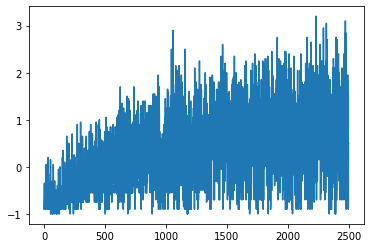

In [25]:
plot_line(episode_reward_history)

Compare with random model<br>
> running reward: 2.46 at episode 399, frame count 10400 (this is the average of the last 100 games)

In [33]:
# Using the wrappers for the environment
from gym.wrappers import RecordVideo
env = gym.make("ALE/Riverraid-v5")
env = ObservationWrapper(RewardWrapper(ActionWrapper(ConcatObs(FireResetEnv(env), k=4, DEATH_REWARD=1000)), CLIP=False, SCALE=True), GRAYSCALE=True, NORMALIZE=True)
# env = RecordVideo(env, video_folder=WORKING_DIRECTORY+"videos/", name_prefix="random_model_ym1")
obs = env.reset()

num_actions = 18
n_episodes_random = 1000
episode_reward_history = np.zeros(n_episodes_random)
episode_count = 0
while episode_count < n_episodes_random:
    state = np.array(env.reset())
    episode_reward = 0

    done = False
    while not done:

        action = np.random.choice(num_actions)
        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            break

    episode_reward_history[episode_count] = episode_reward
    episode_count += 1
    if episode_count%100 == 0:
        print(episode_count)

100
200
300
400
500
600
700
800
900
1000


In [34]:
# Save the progress arrays
np.save(WORKING_DIRECTORY + "RANDOM_" + str(n_episodes_random) + "_episode_reward_history", episode_reward_history)

# describe_arr(episode_reward_history)

count:1000, min:-1.0, max:1.1, mean:-0.6601500000000001, std:0.29532097368795196


count:1000, min:-1.0, max:1.1, mean:-0.6601500000000001, std:0.29532097368795196


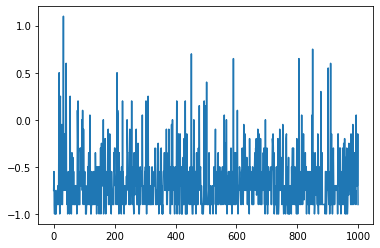

In [48]:
rand_mod_history = np.load(WORKING_DIRECTORY + "RANDOM_" + str(1000) + "_episode_reward_history.npy")
describe_arr(rand_mod_history)
plot_line(rand_mod_history)

In [26]:
# Record video of random to check whether it runs for a single life or not - seems fine

Record video to check

In [43]:
from gym.wrappers import RecordVideo
env = gym.make("ALE/Riverraid-v5")
env = ObservationWrapper(RewardWrapper(ActionWrapper(ConcatObs(FireResetEnv(env), k=4, DEATH_REWARD=1000)), CLIP=False, SCALE=True), GRAYSCALE=True, NORMALIZE=True)
env = RecordVideo(env, video_folder=WORKING_DIRECTORY+"videos/", name_prefix="ym1_implementation1")

# env.seed(100)
obs = env.reset()

n_episodes = 1
episode_count = 0

while episode_count < n_episodes:  # Run until solved
    state_next = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        state_tensor = tf.convert_to_tensor(state_next)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = q_net(state_tensor, training=False)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward
        episode_count += 1

        if done:
            break

/home/yash/Desktop/Courses/CS2470/Final_Project/repo/proj_env_2/lib/python3.7/site-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /home/yash/Desktop/Courses/CS2470/Final_Project/working_dir/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"
/home/yash/Desktop/Courses/CS2470/Final_Project/repo/proj_env_2/lib/python3.7/site-packages/gym/wrappers/monitoring/video_recorder.py:422: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np.__version__
